In [3]:
import os, re
import dill
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

## Load Data

* ### create df of name and label

In [121]:
img_path = os.path.join(os.getcwd(), "data/raw_data/img_nparrays")
# names = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]
names = [f for f in os.listdir(img_path) if any(c.isdigit() for c in f)]
labels = [re.sub(r'\d+', '', name) for name in names]
paths = [os.path.join(img_path, f) for f in names]
dict_df = pd.DataFrame(zip(names,paths, labels), columns=['name','path', 'label'], dtype=str)
dict_df.head()

,name,path,label
0,paper354,/Users/loaner/Documents/github/trash-classifie...,paper
1,cardboard188,/Users/loaner/Documents/github/trash-classifie...,cardboard
2,plastic389,/Users/loaner/Documents/github/trash-classifie...,plastic
3,paper166,/Users/loaner/Documents/github/trash-classifie...,paper
4,paper502,/Users/loaner/Documents/github/trash-classifie...,paper


* ### Sanity check: data size and distribution

total sample size: 2527
{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


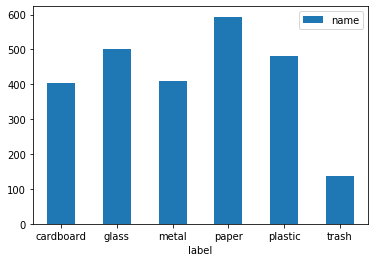

In [122]:
class_ct = dict_df.groupby(dict_df['label']).count()
print("total sample size: %d" % len(dict_df))
print(class_ct['name'].to_dict())
class_ct.reset_index().plot.bar(x='label', y='name', rot=0)

## SGD Classifier (online learn)

In [123]:
import skimage
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

* ### Data augmentation function

In [124]:
# transformations
def rotate(image_array: np.ndarray):
    '''rotate image with a random degree (between left_degree and right_degree)'''
    degree_limit = 30
    rotate_degree = random.uniform(-degree_limit, degree_limit)
    return skimage.transform.rotate(image_array, rotate_degree)*255

def add_noise(image_array: np.ndarray):
    '''add noise to image'''
    return skimage.util.random_noise(image_array)*255

def hor_flip(image_array: np.ndarray):
    '''flipping pixels horizontally'''
    return image_array[:, ::-1]

def ver_flip(image_array: np.ndarray):
    '''flipping pixels vertically'''
    return image_array[::-1, :]

transform_methods = [rotate, add_noise, hor_flip, ver_flip]

In [125]:
# function to make more images

def create_more_trash(target_num, base_file_paths, count_for_name):
    num_transformed = 0
    aug_img_df = pd.DataFrame(columns=dict_df.columns)
    
    base_folder = os.path.join('data/raw_data/resized', 'trash')
    aug_path = 'data/raw_data/aug_data'

    # delete if aug folder already exists (re-aug for every training set)
    if not os.path.exists(aug_path):
        os.mkdir(aug_path)
    else:
        for f in os.listdir(aug_path):
            os.remove(os.path.join(aug_path, f))
    
    while num_transformed <= target_num:
        rand_path = random.choice(base_file_paths)
        base_img = dill.load(open(rand_path, 'rb'))

        new_img = transform_methods[random.randint(0,3)](base_img).astype(np.uint8)
        num_transformed += 1
        
        new_img_name = "trash{}".format(str(count_for_name + num_transformed))
        new_img_path = os.path.join(aug_path, new_img_name)
        
        aug_img_df = aug_img_df.append({"name":new_img_name, "path":new_img_path, "label": "trash"},ignore_index=True)
        dill.dump(new_img, open(new_img_path, 'wb'))
#         imsave(os.path.join('data/raw_data/aug_data_check',new_img_name+".jpg"), new_img)
    return aug_img_df

In [126]:
# plot sample images
from PIL import Image

def plot_imgs_from_df(img_df):
    trash_fig = plt.figure(figsize = (15,15))
    row, col = (5,5)
    
    img_sample_df = img_df.sample(row*col).reset_index(drop=True)
    for index, row in img_sample_df.iterrows():
        img_arr = dill.load(open(row['path'], 'rb'))
        
        plt.subplot(5,5,index+1)
        plt.title(row['name'])
        plt.axis('off')
        
        plt.imshow(img_arr)

* ### Prep for SGD Classifier: train test split, data augmentation on training set

In [136]:
# train test split 
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(dict_df, dict_df['label'], test_size=0.1)

# data augmentation
trash_base_df = X_train_df[X_train_df['label']=='trash']
trash_base_paths = trash_base_df['path'].tolist()
if len(trash_base_df[~trash_base_df['name'].str.contains('trash')])!=0:
    raise "label incorrect"  # sanity check
else:
    avg_numb = int((len(X_train_df)- len(trash_base_paths))/5)
    trash_aug_numb = avg_numb - len(trash_base_paths)
    aug_trash_df = create_more_trash(trash_aug_numb, trash_base_paths, 137)

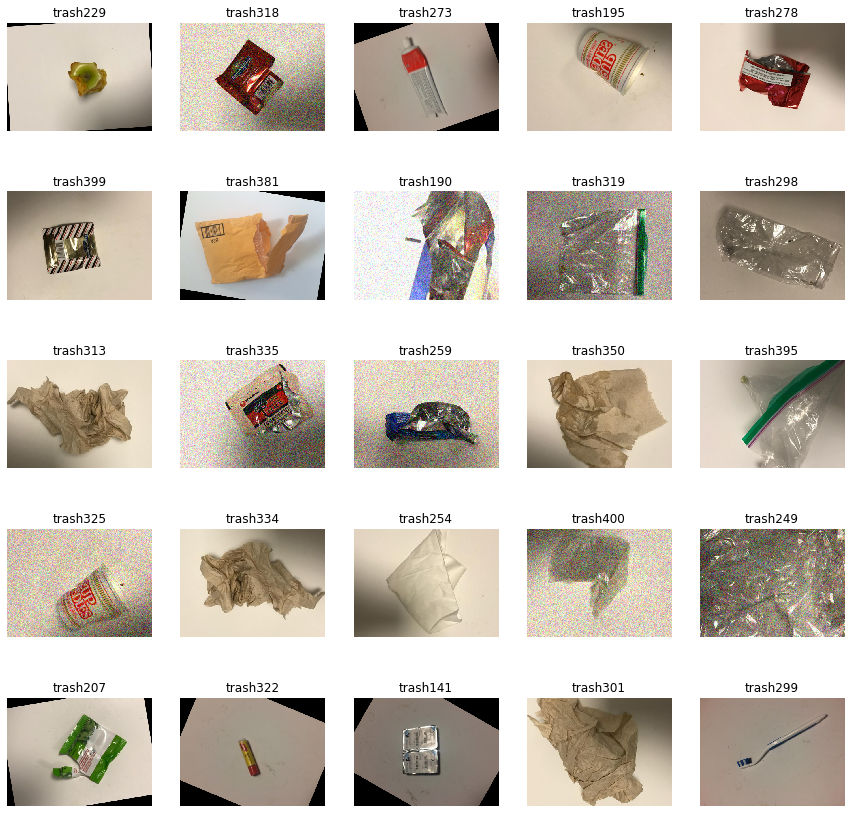

In [97]:
plot_imgs_from_df(aug_trash_df)

In [137]:
# load the augmented data into training set
X_train_df = X_train_df.append(aug_trash_df)
y_train_df = y_train_df.append(aug_trash_df['label'])

* ### Batch Generator (for loading data incrementally)

In [138]:
class batch_generator():
    def __init__(self, train_df, test_df, batch_size=200):
#         self.train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffle train set
        self.train_df = train_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)
        self.batch_size = batch_size

    def get_batches(self, df):
        shuf_df = df.sample(frac=1).reset_index(drop=True) # shuffle train set
        for i in range(0, len(shuf_df), self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
            imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
            labels = shuf_df['label'][i:i+self.batch_size]
            yield (imgs, labels)
    
    def train_batches(self):
        return self.get_batches(self.train_df)
    
    def test_batches(self):
        paths = self.test_df['path']
        imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
        labels = self.test_df['label']
        return (imgs, labels) 

* ### Build SGD Classifier

In [135]:
# model
clf = SGDClassifier(loss='hinge',shuffle=True, n_jobs=5, alpha=0.01)

# batch generator
batch_gen = batch_generator(X_train_df, X_test_df, batch_size=200)

# training
n_iter = 10
partial_train_scores = []
for n in range(n_iter):
    counter = 0
    for X_train_batch, y_train_batch in batch_gen.train_batches():
        clf.partial_fit(X_train_batch, y_train_batch, classes=np.unique(y_train_batch))
        if counter>0:
            partial_train_scores.append(clf.score(X_train_batch, y_train_batch))
        counter += 1
        
# test score
X_test, y_test = batch_gen.test_batches()
test_score = clf.score(X_test, y_test)


In [139]:
# score comparison
print("training score mean: ", np.array(partial_train_scores).mean())
print("test score: ", test_score)

training score mean:  0.39158895405669597
test score:  0.3952569169960474


In [140]:
# prediction
y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   cardboard       0.31      0.71      0.43        68
       glass       0.41      0.48      0.45       116
       metal       0.42      0.32      0.37        71
       paper       0.80      0.09      0.17       129
     plastic       0.42      0.64      0.51        96
       trash       0.00      0.00      0.00        26

    accuracy                           0.40       506
   macro avg       0.39      0.37      0.32       506
weighted avg       0.48      0.40      0.35       506



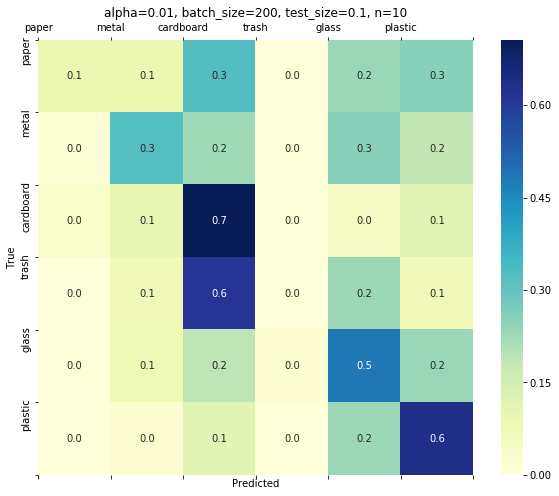

In [141]:
# results visulization
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(classification_report(y_test, y_pred))

categories = ['paper','metal','cardboard','trash','glass','plastic']
cm = confusion_matrix(y_test, y_pred,labels=categories)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm,categories,categories)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(df_cm,annot=True,fmt=".1f",cmap="YlGnBu")
cax = ax.matshow(cm)
plt.title("alpha=0.01, batch_size=200, test_size=0.1, n=10")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [4]:
import cv2
from PIL import Image

def extract_orb(img):
    orb = cv2.ORB_create()
    keypts, descriptor = orb.detectAndCompute(img, None)
    return keypts, descriptor

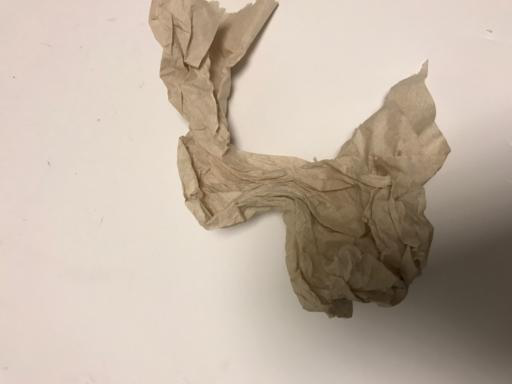

In [30]:
img_test = dill.load(open('data/raw_data/img_nparrays/trash30', 'rb'))
Image.fromarray(img_test)

In [31]:
kp, orb_desc = extract_orb(img_test)
orb_desc.shape

(472, 32)

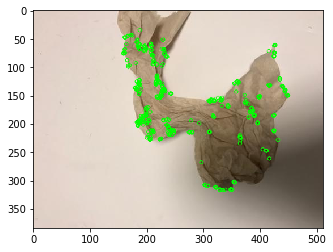

(<matplotlib.image.AxesImage at 0x133df7bd0>, None)

In [32]:
img2 = cv2.drawKeypoints(img_test, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

In [215]:
im_arr = [dill.load(open(p, 'rb')) for p in ['data/raw_data/img_nparrays/metal233',\
                                                      'data/raw_data/img_nparrays/paper95']]

imgs = np.asarray([i.flatten() for i in im_arr])
orbs = np.asarray([extract_orb(i) for i in im_arr])

In [216]:
orbs

array([[list([<KeyPoint 0x1222d0420>, <KeyPoint 0x1222d0d20>, <KeyPoint 0x1222d0960>, <KeyPoint 0x1222d0630>, <KeyPoint 0x1222d0ae0>, <KeyPoint 0x1222d01b0>, <KeyPoint 0x1222d09f0>, <KeyPoint 0x1222d0b40>, <KeyPoint 0x1222d07e0>, <KeyPoint 0x1222d08a0>, <KeyPoint 0x1222d0210>, <KeyPoint 0x1222d0c30>, <KeyPoint 0x1222d0300>, <KeyPoint 0x1222d0c90>, <KeyPoint 0x1284275d0>, <KeyPoint 0x128427600>, <KeyPoint 0x128427870>, <KeyPoint 0x1284277b0>, <KeyPoint 0x128427c00>, <KeyPoint 0x128427de0>, <KeyPoint 0x128427ab0>, <KeyPoint 0x128427090>, <KeyPoint 0x128427c90>, <KeyPoint 0x128427cc0>, <KeyPoint 0x128427270>, <KeyPoint 0x1284278d0>, <KeyPoint 0x128427cf0>, <KeyPoint 0x1284272a0>, <KeyPoint 0x128427630>, <KeyPoint 0x128427030>, <KeyPoint 0x128427150>, <KeyPoint 0x1284273c0>, <KeyPoint 0x128427540>, <KeyPoint 0x128427060>, <KeyPoint 0x128427750>, <KeyPoint 0x128427c60>, <KeyPoint 0x128427990>, <KeyPoint 0x128427c30>, <KeyPoint 0x128427450>, <KeyPoint 0x128427120>, <KeyPoint 0x128427780>, <K

In [177]:
def extract_sift(img):
    sift = cv2.SIFT()
    
    kps = sift.detect(img, None)
    image_blue = [[pixel[0] for pixel in row] for row in img]
    image_green = [[pixel[1] for pixel in row] for row in img]
    image_red = [[pixel[2] for pixel in row] for row in img]
    (_, desc_blue) = sift.compute(np.array(image_blue), kps) 
    (_, desc_green) = sift.compute(np.array(image_green), kps) 
    (_, desc_red) = sift.compute(np.array(image_red), kps) 
    if desc_blue is None:
        desc_blue = []
    if desc_green is None:
        desc_green = []
    if desc_red is None:
        desc_red = []
    # Concat SIFT descriptor for all 3 channels into 1 384-dim vector
    desc = [combine_desc(b, g, r) for (b, g, r) in zip(desc_blue, desc_green, desc_red)] 
    return desc

In [178]:
sift_desc = extract_sift(img_test)
sift_desc

AttributeError: module 'cv2.cv2' has no attribute 'SIFT'

In [70]:
from skimage.color import rgb2grey
from skimage.feature import hog

def extract_hog(img_arr):
    grey_image = rgb2grey(img_arr)
    new_arr, hog_img = hog(grey_image, orientations=9,pixels_per_cell=(8, 8), visualize=True,\
                           cells_per_block=(3, 3), transform_sqrt=True, block_norm="L2-Hys")
#     flat_features = np.hstack((hog_features))
    return new_arr, hog_img

In [73]:
hog_arr, hog_img = extract_hog(img_test)

(231012,)


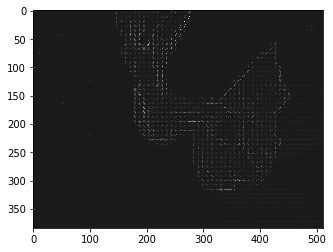

In [74]:
plt.imshow(hog_img, cmap=plt.cm.gray, alpha=0.9)
print(hog_arr.shape)

In [117]:

def extract_hog(img_arr):
    grey_image = rgb2grey(img_arr)
    new_arr = hog(grey_image, orientations=9,pixels_per_cell=(8, 8),\
                           cells_per_block=(3, 3), transform_sqrt=True, block_norm="L2-Hys")
#     flat_features = np.hstack((hog_features))
    return new_arr

In [119]:
class batch_generator():
    def __init__(self, train_df, test_df, batch_size=200, feature="color"):
#         self.train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffle train set
        self.train_df = train_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)
        self.batch_size = batch_size
        self.feature=feature

    def get_batches(self, df):
        shuf_df = df.sample(frac=1).reset_index(drop=True) # shuffle train set
        for i in range(0, len(shuf_df), self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
            labels = shuf_df['label'][i:i+self.batch_size]
            im_arr = [dill.load(open(p, 'rb')) for p in paths]
            
            if self.feature == "color":
                trans_arr = np.asarray([i.flatten() for i in im_arr])
            elif self.feature == "orb":
                trans_arr = np.asarray([extract_orb(i) for i in im_arr])
            elif self.feature == "hog":
                trans_arr = np.asarray([extract_hog(i) for i in im_arr])
                
            yield trans_arr, labels
    
    def train_batches(self):
        return self.get_batches(self.train_df)
    
    def test_batches(self):
        paths = self.test_df['path']
#         imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
        im_arr = np.asarray([dill.load(open(p, 'rb')) for p in paths])

        if self.feature == "color":
            trans_arr = np.asarray([i.flatten() for i in im_arr])
        elif self.feature == "orb":
            trans_arr = np.asarray([extract_orb(i) for i in im_arr])
        elif self.feature == "hog":
            trans_arr = np.asarray([extract_hog(i) for i in im_arr])

        labels = self.test_df['label']
        return trans_arr, labels

In [90]:
# train test split 
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(dict_df, dict_df['label'], test_size=0.2)

# data augmentation
trash_base_df = X_train_df[X_train_df['label']=='trash']
trash_base_paths = trash_base_df['path'].tolist()
if len(trash_base_df[~trash_base_df['name'].str.contains('trash')])!=0:
    raise "label incorrect"  # sanity check
else:
    avg_numb = int((len(X_train_df)- len(trash_base_paths))/5)
    trash_aug_numb = avg_numb - len(trash_base_paths)
    aug_trash_df = create_more_trash(trash_aug_numb, trash_base_paths, 137)

# load the augmented data into training set
X_train_df = X_train_df.append(aug_trash_df)
y_train_df = y_train_df.append(aug_trash_df['label'])

In [120]:
# model
clf = SGDClassifier(loss='hinge',shuffle=True, n_jobs=5, alpha=0.001)

# batch generator
batch_gen = batch_generator(X_train_df, X_test_df, batch_size=200, feature='hog')

# training
n_iter = 10
partial_train_scores = []
for n in range(n_iter):
    counter = 0
    for X_train_batch, y_train_batch in batch_gen.train_batches():
        print(X_train_batch)
#         clf.partial_fit(X_train_batch, y_train_batch, classes=np.unique(y_train_batch))
#         if counter>0:
#             partial_train_scores.append(clf.score(X_train_batch, y_train_batch))
#         counter += 1
        
# # test score
# X_test, y_test = batch_gen.test_batches()
# test_score = clf.score(X_test, y_test)

[[0.         0.         0.         ... 0.02532862 0.         0.        ]
 [0.28430486 0.         0.         ... 0.         0.         0.        ]
 [0.16856738 0.05095401 0.08789041 ... 0.04534688 0.12300567 0.17913957]
 ...
 [0.16585418 0.10327547 0.10573456 ... 0.03363337 0.06925471 0.05646859]
 [0.12200982 0.         0.08627397 ... 0.         0.         0.        ]
 [0.09986848 0.10146755 0.14276982 ... 0.04221218 0.04268896 0.04235664]]


KeyboardInterrupt: 